In [1]:
from typing import Tuple
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Define functions

The function for training `QDA` :
- takes the inputs : $X_{app}$ (training input matrix $n, p$), $z_{app}$ (binary class indicator matrix $n, K$), $m_{prior}$ (Gaussian prior expectation matrix $K, p$), $df_{exp}$ (Gaussian prior shrinkage parameter), $S_{prior}$ (covariance matrix $p, p, K$ for the inverse -Wishart prior), $df_{cov}$ (degree of freedom of the inverse-Wishart prior)
- provides : $pi$ (vector $K, 1$ of class proportions), $mu$ (estimated expectation matrix $K, p$), $Sig$ (estimated covariance matrices $p, p, K$)

In [2]:
def data_processing(file_url : str,
                    n_components_pca : int = None,
                    test_size : float = 0.3) -> Tuple:
    """
    :param file_url: Path to dataset file
    :param n_components_pca : Number of principal components we extract from the dataset
    :param test_size : Number from 0 to 1, the portion of test set
    """
    # read data from cvs file and convert it into numpy array
    data = pd.read_csv(file_url, header=0)
    data = data.to_numpy()
    
    # apply PCA if necessary
    if n_components_pca is not None:
        data_y = data[:, -1]
        data_X = data[:, :-1]
        pca = PCA(n_components=n_components_pca)
        data_X = pca.fit_transform(data_X)
        data = np.hstack((data_X, data_y.reshape((-1,1))))
    
    # transform outputs (labels) into indices to easier manipulate
    classes = sorted(collections.Counter(list(data[:, -1])).keys())
    classes_with_index = {}
    K = len(classes)
    n, p = data.shape[0], data.shape[1] - 1
    for i_class in range(K):
        classes_with_index[i_class] = classes[i_class]
        data[data[:, -1] == classes[i_class], -1] = i_class
    print("Ours classes are enumerated as bellow : \n", classes_with_index)
    
    # split data to training set and test set
    if test_size > 1 or test_size < 0:
        raise IndexError("invalid value of test_size")
    else:
        Xapp, Xtst, yapp, ytst = train_test_split(data[:, :-1], data[:, -1],
                                                  test_size=test_size)
        Zapp = np.zeros((len(yapp), K))
        Ztst = np.zeros((len(ytst), K))
        for i in range(len(yapp)):
            Zapp[i, int(yapp[i])] = 1
        for i in range(len(ytst)):
            Ztst[i, int(ytst[i])] = 1
    
    # compute mprior (expected value) and Sprior (covariance's matrices)
    mprior = np.zeros((K, p))
    Sprior = np.zeros((p, p, K))
    for j in range(K):
        temp = data[data[:, -1] == j, :-1]
        temp = temp.astype(float)
        mprior[j, :] = temp.mean(axis = 0)
        Sprior[:, :, j] = np.cov(temp, rowvar=False)
    return Xapp, Zapp, Xtst, Ztst, mprior, Sprior

We define a `data_processing` function to test different dataset. The function does respectively :
- Read the dataset by the `pandas` library and transform it to the one in form of the `numpy` library in order to facilitate our next works.
- Apply PCA filtering process to the dataset if necessary.
- Sort all classes of the dataset and display their enumeration
- Separate the dataset into training and test ones by `cut_off` coefficient predefined at `0.9`
- Calculate the prior expectation and variance based on the training set

In [3]:
def QDA(Xapp : np.array,
        zapp  : np.array,
        mprior : np.array,
        df_exp : float,
        Sprior : np.array,
        df_cov : float) -> Tuple:
    """
    :param Xapp: feature of training set
    :param zapp : label of training set
    :param mprior : emperical prior of expected value
    :param df_exp : shrinkage parameter
    :param Sprior : emperical prior of covariance matrices
    :param df_cov : degrees of freedom of the inverse-Wishart prior
    """
    
    # n : number of samples, p : number of feature, K : number of classes
    n, p, K =  Xapp.shape[0], Xapp.shape[1], zapp.shape[1]
    
    # compute estimators of pi, mu, Sig
    pi = np.zeros(K)
    mu = np.zeros((K, p))
    B = np.zeros((p, p, n))
    Sig = np.zeros((p, p, K))
    
    pi = np.mean(zapp, axis=0)
    for j in range(K):
        mu[j, :] = (sum(zapp[i, j] * Xapp[i, :] for i in range(n)) 
                    + df_exp * mprior[j, :]) / (sum(zapp[:, j]) + df_exp)
        
        for i in range(n):
            temp = (Xapp[i, :] - mprior[j, :]).reshape((p, -1))
            B[:, :, i] = temp @ temp.T
        
        Sig[:, :, j] = (sum((zapp[i, j] * B[:, :, i]) for i in range(n)) + 
                        df_exp * (mu[j, :] - mprior[j, :]) @ (mu[j, :] - 
                                                              mprior[j, :]).T + 
                        Sprior[:, :, j].T) / (sum(zapp[:, j]) + df_cov + p + 2)
    return pi, mu, Sig

In [4]:
def QDA_without_prior(Xapp : np.array,
                      zapp  : np.array) -> Tuple:
    """
    :param Xapp: feature of training set
    :param zapp : label of training set
    """
    # n : number of samples, p : number of feature, K : number of classes
    n, p, K =  Xapp.shape[0], Xapp.shape[1], zapp.shape[1]
    
    # compute estimators of pi, mu, Sig
    pi = np.zeros(K)
    mu = np.zeros((K, p))
    B = np.zeros((p, p, n))
    Sig = np.zeros((p, p, K))
    
    pi = np.mean(zapp, axis=0)
    for j in range(K):
        mu[j, :] = sum(zapp[i, j] * Xapp[i, :] for i in range(n))
        
        for i in range(n):
            temp = (Xapp[i, :] - mu[j, :]).reshape((p, -1))
            
            B[:, :, i] = temp @ temp.T
        
        Sig[:, :, j] = sum((zapp[i, j] *
                            B[:, :, i]) for i in range(n)) / sum(zapp[:, j])
    return pi, mu, Sig

The function for evaluating test set `evaluation` :
- takes the inputs : $X_{tst}$ (test input matrix $n, p$), $pi$ (vector $K, 1$ of class proportions), $mu$ (estimated expectation matrix $K, p$), $Sig$ (estimated covariance matrices $p, p, K$)
- provides : $prob$ (matrix $n, K$ of estimated class posterior probabilities) and $pred$ (vector $n, 1$ of corresponding decisions)

In [5]:
def evaluation(Xtst : np.array,
               pi : np.array,
               mu : np.array,
               Sig : np.array) -> Tuple:
    """
    :param Xtst: feature of test set
    :param pi : estimator of  class proportions
    :param mu : estimator of  expectations
    :param Sig : estimator of  covariance matrices
    """
    # n : number of samples, p : number of feature, K : number of classes
    n, p, K = Xtst.shape[0], Xtst.shape[1], len(pi)
    
    prob = np.zeros((n, K))
    pred = np.zeros(n)
    
    # function which compute density
    f = lambda x, mu, Sig: (2*np.pi)**(-len(x)/2) * np.linalg.det(Sig)**(-1/2) * np.exp((-1/2) *(x - mu).T
                                                                                        @ np.linalg.inv(Sig)
                                                                                        @ (x - mu))
   
    # compute probabilitie's vector for K classes
    for j in range(K):
        for i in range(n):
            total = sum(pi[k] * f(Xtst[i, :], mu[k, :],
                                  Sig[:, :, k]) for k in range(K))
            prob[i, j] = pi[j] * f(Xtst[i, :], mu[j, :], Sig[:, :, j]) / total
        
    pred = np.argmax(prob, axis=1)
    
    return prob, pred

## Optdigits test

The `optdigits` dataset has many zero elements that make itselft correlated. That's why the result from the inital training datatset is badly evaluated. We then apply a PCA filtering process with number of principal components depending on the `cut_off` coefficient (rank of training set) in order to eliminate the correlated ones. As a result, we get much better performance. <br>
For the choice of the shrinkage parameter $df_{exp}$ and the degree of freedom $df_{co}v$, we a priori choose $df_{exp} = 10$ and $df_{cov} = 300$ for this dataset and also the next ones.

In [6]:
Xapp_opt, Zapp_opt, Xtst_opt, Ztst_opt, mprior_opt, Sprior_opt = data_processing(
                                            "dataset/optdigits.csv", n_components_pca=20)

df_exp_opt = 0.1
df_cov_opt = Xapp_opt.shape[1] + 1

pi_opt, mu_opt, Sig_opt = QDA(Xapp_opt, Zapp_opt, mprior_opt, df_exp_opt, Sprior_opt, df_cov_opt)
prob_opt, pred_opt = evaluation(Xtst_opt, pi_opt, mu_opt, Sig_opt)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_opt, axis=1), pred_opt))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_opt, axis=1), pred_opt))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_opt, axis=1), pred_opt, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
-----------------------------------------------------------


Confusion matrix

 [[174   0   0   0   1   0   0   0   1   0]
 [  0 178   0   1   1   0   0   0   0   2]
 [  0   1 144   0   0   0   0   0   0   0]
 [  0   0   0 160   0   2   0   1   1   1]
 [  0   0   0   0 162   0   0   0   0   1]
 [  0   0   0   1   0 145   0   0   2   1]
 [  0   0   0   0   0   0 169   0   2   0]
 [  0   0   0   0   0   0   0 206   0   0]
 [  0   2   0   0   0   0   0   0 169   1]
 [  0   0   0   1   1   0   0   1   1 153]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       1.00      0.99      0.99       176
           1       0.98      0.98      0.98       182
           2       1.00      0.99      1.00       145
           3       0.98      0.97      0.98       165
        

In [7]:
pi_opt_2, mu_opt_2, Sig_opt_2 = QDA_without_prior(Xapp_opt, Zapp_opt)
prob_opt_2, pred_opt_2 = evaluation(Xtst_opt, pi_opt_2, mu_opt_2, Sig_opt_2)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_opt, axis=1), pred_opt_2))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_opt, axis=1), pred_opt_2))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_opt, axis=1), pred_opt_2, average='weighted'))

-----------------------------------------------------------


Confusion matrix

 [[173   0   0   0   1   0   0   0   1   1]
 [  1 176   0   1   1   1   0   0   0   2]
 [  0   1 143   0   0   0   0   0   0   1]
 [  0   0   0 159   1   1   0   1   3   0]
 [  0   0   0   0 162   0   0   0   0   1]
 [  0   0   0   0   0 144   0   0   1   4]
 [  0   0   0   0   0   0 168   0   2   1]
 [  0   0   0   0   0   1   0 205   0   0]
 [  0   2   0   5   1   0   0   0 162   2]
 [  0   0   0   0   1   0   0   0   3 153]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       0.99      0.98      0.99       176
           1       0.98      0.97      0.98       182
           2       1.00      0.99      0.99       145
           3       0.96      0.96      0.96       165
           4       0.97      0.99      0.98       163
           5       0.98      0.97      0.97       149
           6       1.00

Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}
Ours classes are enumerated as bellow : 
 {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0}


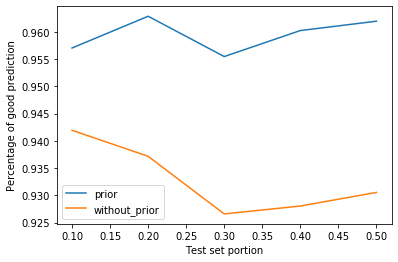

In [8]:
df_exp_opt = 0.1
df_cov_opt = Xapp_opt.shape[1] + 1
cuts_off = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(cuts_off))
prediction_without_prior = np.zeros(len(cuts_off))

for i in range(len(cuts_off)):
    Xapp_opt, Zapp_opt, Xtst_opt, Ztst_opt, mprior_opt, Sprior_opt = data_processing(
                                            "dataset/optdigits.csv", n_components_pca=10, test_size=cuts_off[i])
    
    pi_opt, mu_opt, Sig_opt = QDA(Xapp_opt, Zapp_opt, mprior_opt, df_exp_opt, Sprior_opt, df_cov_opt)
    prob_opt, pred_opt = evaluation(Xtst_opt, pi_opt, mu_opt, Sig_opt)
    prediction[i] = precision_score(np.argmax(Ztst_opt, axis=1), pred_opt, average='weighted')
    
    pi_opt_2, mu_opt_2, Sig_opt_2 = QDA_without_prior(Xapp_opt, Zapp_opt)
    prob_opt_2, pred_opt_2 = evaluation(Xtst_opt, pi_opt_2, mu_opt_2, Sig_opt_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_opt, axis=1), pred_opt_2, average='weighted')

plt.plot(cuts_off, prediction)
plt.plot(cuts_off, prediction_without_prior)
plt.xlabel("Test set portion")
plt.ylabel("Percentage of good prediction")
plt.legend(["prior", "without_prior"])
plt.show()

## Page Blocks test

In [9]:
Xapp_pag, Zapp_pag, Xtst_pag, Ztst_pag, mprior_pag, Sprior_pag = data_processing("dataset/page-blocks.csv")

df_exp_pag = 0.1
df_cov_pag = Xapp_pag.shape[1] + 20

pi_pag, mu_pag, Sig_pag = QDA(Xapp_pag, Zapp_pag, mprior_pag, df_exp_pag, Sprior_pag, df_cov_pag)
prob_pag, pred_pag = evaluation(Xtst_pag, pi_pag, mu_pag, Sig_pag)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_pag, axis=1), pred_pag))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_pag, axis=1), pred_pag))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_pag, axis=1), pred_pag, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
-----------------------------------------------------------


Confusion matrix

 [[1436   14    1   11   12]
 [  19   70    0    6    0]
 [   0    0    4    0    5]
 [   2    0    1   20    3]
 [  16    1    0    0   21]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1474
           1       0.82      0.74      0.78        95
           2       0.67      0.44      0.53         9
           3       0.54      0.77      0.63        26
           4       0.51      0.55      0.53        38

    accuracy                           0.94      1642
   macro avg       0.70      0.70      0.69      1642
weighted avg       0.95      0.94      0.95      1642

-----------------------------------------------------------


Precision score

 0.9468499658956686


In [10]:
pi_pag_2, mu_pag_2, Sig_pag_2 = QDA_without_prior(Xapp_pag, Zapp_pag)
prob_pag_2, pred_pag_2 = evaluation(Xtst_pag, pi_pag_2, mu_pag_2, Sig_pag_2)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_pag, axis=1), pred_pag_2))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_pag, axis=1), pred_pag_2))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_pag, axis=1), pred_pag_2, average='weighted'))

-----------------------------------------------------------


Confusion matrix

 [[1409   20    1   12   32]
 [  10   77    0    8    0]
 [   0    0    7    0    2]
 [   1    0    1   21    3]
 [  15    1    0    0   22]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1474
           1       0.79      0.81      0.80        95
           2       0.78      0.78      0.78         9
           3       0.51      0.81      0.63        26
           4       0.37      0.58      0.45        38

    accuracy                           0.94      1642
   macro avg       0.69      0.79      0.72      1642
weighted avg       0.95      0.94      0.94      1642

-----------------------------------------------------------


Precision score

 0.947882339604113


Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}


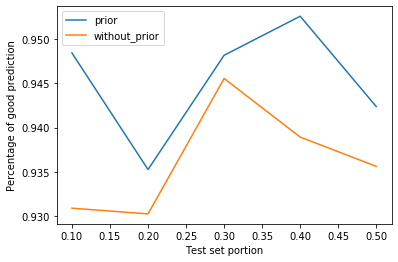

In [11]:
cuts_off = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(cuts_off))
prediction_without_prior = np.zeros(len(cuts_off))

for i in range(len(cuts_off)):
    Xapp_pag, Zapp_pag, Xtst_pag, Ztst_pag, mprior_pag, Sprior_pag = data_processing("dataset/page-blocks.csv",
                                                                                    n_components_pca=8)

    pi_pag, mu_pag, Sig_pag = QDA(Xapp_pag, Zapp_pag, mprior_pag, df_exp_pag, Sprior_pag, df_cov_pag)
    prob_pag, pred_pag = evaluation(Xtst_pag, pi_pag, mu_pag, Sig_pag)
    prediction[i] = precision_score(np.argmax(Ztst_pag, axis=1), pred_pag, average='weighted')

    pi_pag_2, mu_pag_2, Sig_pag_2 = QDA_without_prior(Xapp_pag, Zapp_pag)
    prob_pag_2, pred_pag_2 = evaluation(Xtst_pag, pi_pag_2, mu_pag_2, Sig_pag_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_pag, axis=1), pred_pag_2, average='weighted')

plt.plot(cuts_off, prediction)
plt.plot(cuts_off, prediction_without_prior)
plt.xlabel("Test set portion")
plt.ylabel("Percentage of good prediction")
plt.legend(["prior", "without_prior"])
plt.show()

## Satimage test

In [12]:
Xapp_sat, Zapp_sat, Xtst_sat, Ztst_sat, mprior_sat, Sprior_sat = data_processing("dataset/satimage.csv")

df_exp_sat = 0.1
df_cov_sat = Xapp_sat.shape[1] + 1

pi_sat, mu_sat, Sig_sat = QDA(Xapp_sat, Zapp_sat, mprior_sat, df_exp_sat, Sprior_sat, df_cov_sat)
prob_sat, pred_sat = evaluation(Xtst_sat, pi_sat, mu_sat, Sig_sat)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_sat, axis=1), pred_sat))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_sat, axis=1), pred_sat))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_sat, axis=1), pred_sat, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
-----------------------------------------------------------


Confusion matrix

 [[460   1   3   0   8   0]
 [  0 210   0   0   1   0]
 [  8   2 374   6   7   8]
 [  0   8  62  47   8  73]
 [  5  11   0   0 166  17]
 [  0  11  19  15  20 379]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       0.97      0.97      0.97       472
           1       0.86      1.00      0.93       211
           2       0.82      0.92      0.87       405
           3       0.69      0.24      0.35       198
           4       0.79      0.83      0.81       199
           5       0.79      0.85      0.82       444

    accuracy                           0.85      1929
   macro avg       0.82      0.80      0.79      1929
weighted avg       0.84      0.85      0.83      1929

------------------------------------

In [13]:
pi_sat_2, mu_sat_2, Sig_sat_2 = QDA_without_prior(Xapp_sat, Zapp_sat)
prob_sat_2, pred_sat_2 = evaluation(Xtst_sat, pi_sat_2, mu_sat_2, Sig_sat_2)

print("-----------------------------------------------------------")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_sat, axis=1), pred_sat_2))
print("-----------------------------------------------------------")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_sat, axis=1), pred_sat_2))
print("-----------------------------------------------------------")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_sat, axis=1), pred_sat_2, average='weighted'))

-----------------------------------------------------------
Confusion matrix

 [[459   1   2   1   9   0]
 [  0 210   0   0   1   0]
 [ 13   3 359  13  11   6]
 [  1   9  57  69   7  55]
 [ 11  12   5   6 147  18]
 [  1  11  29  25  22 356]]
-----------------------------------------------------------
Classification report

               precision    recall  f1-score   support

           0       0.95      0.97      0.96       472
           1       0.85      1.00      0.92       211
           2       0.79      0.89      0.84       405
           3       0.61      0.35      0.44       198
           4       0.75      0.74      0.74       199
           5       0.82      0.80      0.81       444

    accuracy                           0.83      1929
   macro avg       0.79      0.79      0.79      1929
weighted avg       0.82      0.83      0.82      1929

-----------------------------------------------------------
Precision score

 0.8191753347380235


Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}
Ours classes are enumerated as bellow : 
 {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0}


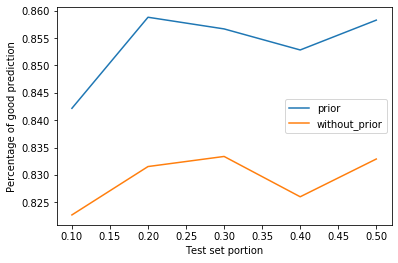

In [14]:
cuts_off = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(cuts_off))
prediction_without_prior = np.zeros(len(cuts_off))

for i in range(len(cuts_off)):
    Xapp_sat, Zapp_sat, Xtst_sat, Ztst_sat, mprior_sat, Sprior_sat = data_processing("dataset/satimage.csv")

    pi_sat, mu_sat, Sig_sat = QDA(Xapp_sat, Zapp_sat, mprior_sat, df_exp_sat, Sprior_sat, df_cov_sat)
    prob_sat, pred_sat = evaluation(Xtst_sat, pi_sat, mu_sat, Sig_sat)
    prediction[i] = precision_score(np.argmax(Ztst_sat, axis=1), pred_sat, average='weighted')

    pi_sat_2, mu_sat_2, Sig_sat_2 = QDA_without_prior(Xapp_sat, Zapp_sat)
    prob_sat_2, pred_sat_2 = evaluation(Xtst_sat, pi_sat_2, mu_sat_2, Sig_sat_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_sat, axis=1), pred_sat_2, average='weighted')

plt.plot(cuts_off, prediction)
plt.plot(cuts_off, prediction_without_prior)
plt.xlabel("Test set portion")
plt.ylabel("Percentage of good prediction")
plt.legend(["prior", "without_prior"])
plt.show()

## Segment test

In [15]:
Xapp_seg, Zapp_seg, Xtst_seg, Ztst_seg, mprior_seg, Sprior_seg = data_processing("dataset/segment.csv",
                                                                                n_components_pca=17)

df_exp_seg = 0.5
df_cov_seg = Xapp_seg.shape[1] + 1

pi_seg, mu_seg, Sig_seg = QDA(Xapp_seg, Zapp_seg, mprior_seg, df_exp_seg, Sprior_seg, df_cov_seg)
prob_seg, pred_seg = evaluation(Xtst_seg, pi_seg, mu_seg, Sig_seg)

print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_seg, axis=1), pred_seg))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_seg, axis=1), pred_seg))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_seg, axis=1), pred_seg, average='weighted'))

Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
-----------------------------------------------------------


Confusion matrix

 [[ 92   1   0   0   0   0   1]
 [  0  89   3   0   0   0   2]
 [  0   1  58   0   0   0  46]
 [  0   0   0 103   0   0   0]
 [  0   2   0   0  90   0   0]
 [  0   1   0   0   0  99   0]
 [  0  21   6   0   0   0  78]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       1.00      0.98      0.99        94
           1       0.77      0.95      0.85        94
           2       0.87      0.55      0.67       105
           3       1.00      1.00      1.00       103
           4       1.00      0.98      0.99        92
           5       1.00      0.99      0.99       100
           6       0.61      0.74      0.67       105

    accuracy                           0.88      

In [16]:
pi_seg_2, mu_seg_2, Sig_seg_2 = QDA_without_prior(Xapp_seg, Zapp_seg)
prob_seg_2, pred_seg_2 = evaluation(Xtst_seg, pi_seg_2, mu_seg_2, Sig_seg_2)


print("-----------------------------------------------------------\n\n")
print("Confusion matrix")
print('\n', confusion_matrix(np.argmax(Ztst_seg, axis=1), pred_seg_2))
print("-----------------------------------------------------------\n\n")
print("Classification report")
print('\n', classification_report(np.argmax(Ztst_seg, axis=1), pred_seg_2))
print("-----------------------------------------------------------\n\n")
print("Precision score")
print('\n', precision_score(np.argmax(Ztst_seg, axis=1), pred_seg_2, average='weighted'))

-----------------------------------------------------------


Confusion matrix

 [[ 91   2   0   0   0   0   1]
 [  0  88   3   0   0   0   3]
 [  0   1  58   0   0   0  46]
 [  0   0   0 103   0   0   0]
 [  0   2   0   0  90   0   0]
 [  0   0   0   0   0  99   1]
 [  0  16   6   0   0   0  83]]
-----------------------------------------------------------


Classification report

               precision    recall  f1-score   support

           0       1.00      0.97      0.98        94
           1       0.81      0.94      0.87        94
           2       0.87      0.55      0.67       105
           3       1.00      1.00      1.00       103
           4       1.00      0.98      0.99        92
           5       1.00      0.99      0.99       100
           6       0.62      0.79      0.69       105

    accuracy                           0.88       693
   macro avg       0.90      0.89      0.89       693
weighted avg       0.90      0.88      0.88       693

------------------

Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}
Ours classes are enumerated as bellow : 
 {0: 'brickface', 1: 'cement', 2: 'foliage', 3: 'grass', 4: 'path', 5: 'sky', 6: 'window'}


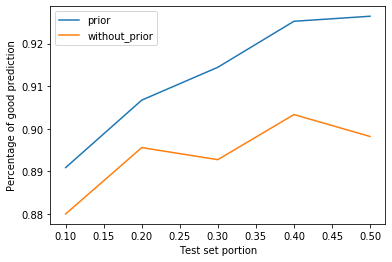

In [17]:
cuts_off = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
prediction = np.zeros(len(cuts_off))
prediction_without_prior = np.zeros(len(cuts_off))

for i in range(len(cuts_off)):
    Xapp_seg, Zapp_seg, Xtst_seg, Ztst_seg, mprior_seg, Sprior_seg = data_processing("dataset/segment.csv",
                                                                                n_components_pca=10)

    pi_seg, mu_seg, Sig_seg = QDA(Xapp_seg, Zapp_seg, mprior_seg, df_exp_seg, Sprior_seg, df_cov_seg)
    prob_seg, pred_seg = evaluation(Xtst_seg, pi_seg, mu_seg, Sig_seg)
    prediction[i] = precision_score(np.argmax(Ztst_seg, axis=1), pred_seg, average='weighted')

    pi_seg_2, mu_seg_2, Sig_seg_2 = QDA_without_prior(Xapp_seg, Zapp_seg)
    prob_seg_2, pred_seg_2 = evaluation(Xtst_seg, pi_seg_2, mu_seg_2, Sig_seg_2)
    prediction_without_prior[i] = precision_score(np.argmax(Ztst_seg, axis=1), pred_seg_2, average='weighted')

plt.plot(cuts_off, prediction)
plt.plot(cuts_off, prediction_without_prior)
plt.xlabel("Test set portion")
plt.ylabel("Percentage of good prediction")
plt.legend(["prior", "without_prior"])
plt.show()

In [18]:
# 0.9766310415063318 1;p+20 ll
# 0.9758926103474012 10;p+20
# 0.9671482548426473 10;p+300 
# v reprensent the least informative -> v high -> cov lower -> more "confident" ????
# high df_cov -> Sig =~~ sampling covariance matrix (in this case Sprior)